In [1]:
import platform
import netket as nk
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import netket as nk
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [95]:
# We always shorten netket as nk
import netket as nk

# Define a 1d chain
L = 4
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

In [96]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

In [97]:
hamiltonian = nk.operator.Heisenberg(hilbert=hi, graph=g)

In [98]:
E, vec = np.linalg.eigh(hamiltonian.to_dense())
min(E)

-8.000000000000002

In [99]:
# from scipy.sparse.linalg import eigsh
# ha = hamiltonian.to_sparse()
# e_gs, psi_gs = eigsh(ha, k=10)
# e_gs = e_gs[0]
# psi_gs = psi_gs.reshape(-1)
# e_gs

In [144]:
Et = np.random.uniform(low=0, high=L, size=None)
Et

2.990693387619497

In [146]:
hamiltonian - 0

LocalOperator(dim=4, acting_on=[(0, 1), (1, 2), (0, 3), (2, 3)], constant=0.0, dtype=float64)

(0.0, 16.0)

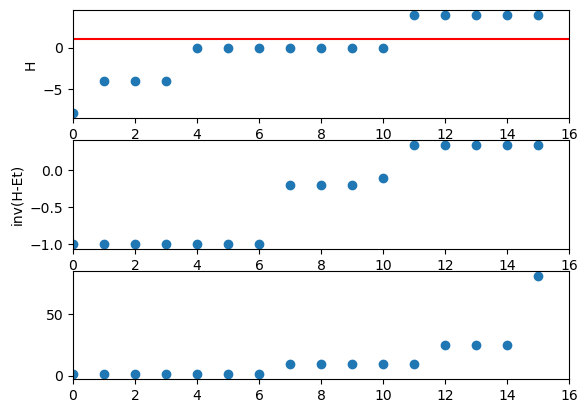

In [165]:
xlim = 16
Et = 1

plt.subplot(3,1,1)
plt.scatter(range(len(E)),E)
plt.plot([0,len(E)],[Et,Et],'r')
plt.xlim([0,xlim])
plt.ylabel("H")

plt.subplot(3,1,2)
inv_ha = np.linalg.inv(  (hamiltonian - Et).to_dense()  )
e_gs, psi_gs = np.linalg.eigh(inv_ha)
plt.scatter(range(len(e_gs)), e_gs)
plt.xlim([0,xlim])
plt.ylabel("inv(H-Et)")

plt.subplot(3,1,3)
ha = (hamiltonian - Et)@(hamiltonian - Et)
ha = ha.to_dense()
e_gs, psi_gs = np.linalg.eigh(ha)
plt.scatter(range(len(e_gs)), e_gs)
plt.xlim([0,xlim])

In [149]:
def to_array(model, parameters):
    # begin by generating all configurations in the hilbert space.
    # all_States returns a batch of configurations that is (hi.n_states, N) large.
    all_configurations = hi.all_states()

    # now evaluate the model, and convert to a normalised wavefunction.
    logpsi = model.apply(parameters, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi


In [150]:
# and like before, we can jit-compile it!
compute_energy_jit = jax.jit(compute_energy, static_argnames="model")

# and we precompute the sparse-hamiltonian to avoid the overhead of re-computing them all the time
hamiltonian_sparse = hamiltonian.to_sparse()
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

hamiltonian_Et = hamiltonian-Et
hamiltonian_Et_jax = hamiltonian_Et.to_pauli_strings().to_jax_operator()
hamiltonian_Et_jax_sparse = hamiltonian_Et_jax.to_sparse()

hamiltonian_Et_squared = (hamiltonian-Et)@(hamiltonian-Et)
hamiltonian_Et_squared_jax = hamiltonian_Et_squared.to_pauli_strings().to_jax_operator()
hamiltonian_Et_squared_jax_sparse = hamiltonian_Et_squared_jax.to_sparse()

/home/kodo/anaconda3/lib/python3.11/site-packages/jax/_src/api_util.py:231: SyntaxWarning: Jitted function has invalid argnames {'model'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [151]:
# from jax import jit
# @jit
def compute_energy(ma, parameters, ha_jax_sparse):
    psi_gs = to_array(ma, parameters)
    return psi_gs.conj().T@(ha_jax_sparse@psi_gs)

def new_loss(ma, parameters, psi_pre):
    psi_gs = to_array(ma, parameters) 
    return psi_gs.conj().T@(hamiltonian_Et_squared_jax_sparse@psi_gs) - 2*psi_pre.conj().T@(hamiltonian_Et_jax_sparse@psi_gs)
#     return psi_gs.conj().T@(hamiltonian_jax_sparse@psi_gs)


def compute_energy_variance(ma, parameters, ha_jax_sparse):
    psi_gs = to_array(ma, parameters)
    energy = psi_gs.conj().T@(ha_jax_sparse@psi_gs)
    vari = psi_gs.conj().T@(hamiltonian_jax_sparse@hamiltonian_jax_sparse@psi_gs) - (psi_gs.conj().T@(hamiltonian_jax_sparse@psi_gs))**2
    return energy, vari


### 3.4 Gradient of the energy

As we used jax so far, we can easily compute the gradient of the energy by simply calling one function: `jax.grad(compute_energy, argnum=1)`, where argnum signals wrt which argument we want to compute the gradient (the 0 is the model, which is not actually an array so we cannot differentiate, the second is the parameters, so that's the one

In [152]:
from functools import partial

# we use partial to directly jit this function. Jitting the top-most will jit everything inside it as well.
# @partial(jax.jit, static_argnames='model')
def compute_gradient(model, parameters, hamiltonian_sparse):
    grad_fun = jax.jacfwd(compute_energy, holomorphic=True, argnums=1)(model, parameters, hamiltonian_sparse)
    return grad_fun

def new_gradient(model, parameters, psi_pre):
    grad_fun = jax.jacfwd(new_loss, holomorphic=True, argnums=1)(model, parameters, psi_pre)
    return grad_fun

In [182]:
# initialise 
from tqdm import tqdm
# model = MF()
model = nk.models.RBM(alpha=1,  param_dtype=complex)
parameters = model.init(jax.random.PRNGKey(0), np.ones((hi.size, )))

logger = nk.logging.RuntimeLog()
epoch = 2000
l_rate = 0.001
en_inv = []
en = []

for i in tqdm(range(epoch)):
    # compute energy and gradient
    psi_pre = hamiltonian_Et_jax_sparse@to_array(model, parameters) #Psi_n
    psi_pre = psi_pre / jnp.linalg.norm(psi_pre) #normalize Psi_n
    gradient = new_gradient(model, parameters, psi_pre)
#     gradient = compute_energy(model, parameters, hamiltonian_jax_sparse)
    
    # update parameters
    parameters = jax.tree_map(lambda x,y:x-l_rate*y, parameters, gradient)
    en.append(compute_energy(model, parameters, hamiltonian_jax_sparse))
    en_inv.append(compute_energy(model, parameters, inv_ha))
    
    
# compute_energy_variance(model, parameters, hamiltonian_jax_sparse)

100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.77it/s]


Text(0, 0.5, 'H')

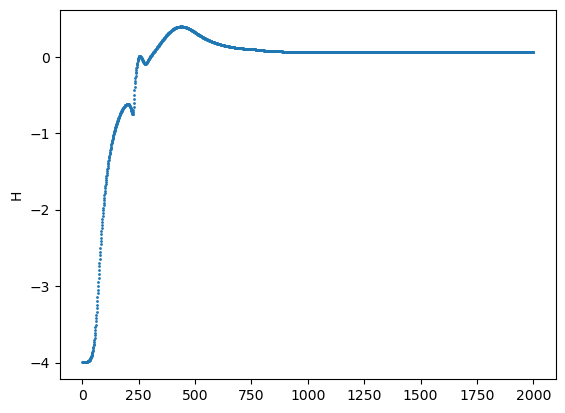

In [186]:
plt.scatter(range(len(en)),np.real(en),s=1)
plt.ylabel("H")

Text(0, 0.5, 'inv(H-Et)')

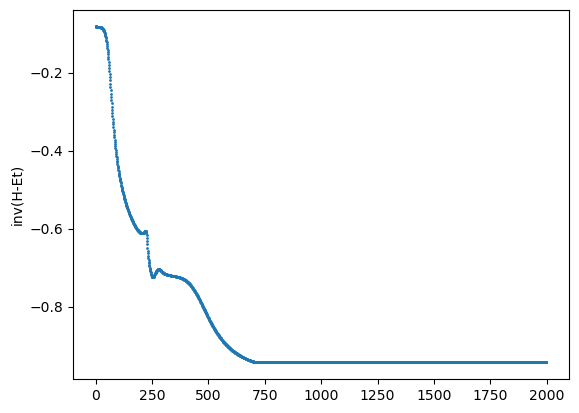

In [187]:
plt.scatter(range(len(en_inv)),np.real(en_inv),s=1)
plt.ylabel("inv(H-Et)")

In [179]:
en[-1]

Array(-0.94237649-2.69370794e-18j, dtype=complex128)

In [180]:
en[0]

Array(-0.08168869+2.75539183e-19j, dtype=complex128)